# Applying AutoTS, pdarima, and H2O libraries

This notebook was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

## Functions for validation and plots

In [1]:
# Additional imports
import pandas as pd
import numpy as np

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def train_test_split_df(dataframe, validation_elements: int=42):
    """ Function for dividing the dataframe into training and test samples
    
    :param dataframe: pandas DataFrame
    :param validation_elements: number of items in the validation sample
    """
    
    source_len = len(dataframe)
    df_train = dataframe.head(source_len - validation_elements)
    df_val = dataframe.tail(validation_elements)
    
    return df_train, df_val

## AutoTS

In [10]:
from autots import AutoTS

# Additional functions for time series forecasting
def show_autots_results(actual_time_series, prediction, len_train_data, y_name='diesel_fuel_kWh'):
    """
    Function for drawing plot with predictions and display metrics

    :param actual_time_series: the entire array with one-dimensional data
    :param prediction: prediction object 
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    lower_forecasts_df = prediction.lower_forecast
    forecasts_df = prediction.forecast
    upper_forecasts_df = prediction.upper_forecast
    
    lower_predicted_values = np.array(lower_forecasts_df[y_name])
    predicted_values = np.array(forecasts_df[y_name])
    upper_predicted_values = np.array(upper_forecasts_df[y_name])

    plt.plot(np.arange(0, len(actual_time_series)),
             actual_time_series, label='Actual values', c='green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)),
             predicted_values, label='AutoTS', c='blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c='black', linewidth=1)
    plt.fill_between(np.arange(len_train_data, len_train_data + len(predicted_values)),
                     lower_predicted_values, upper_predicted_values, color='b', alpha=.05)
    plt.ylabel(y_name, fontsize=15)
    plt.xlabel('Time index', fontsize=15)
    plt.legend(fontsize=15, loc='upper left')
    plt.xlim(len_train_data - 100, len(actual_time_series) + 10)
    plt.grid()
    plt.show()
    
    mse_metric = mean_squared_error(actual_time_series[len_train_data:], predicted_values)
    mae_metric = mean_absolute_error(actual_time_series[len_train_data:], predicted_values)

    print(f'MAE - {mae_metric:.2f}')
    print(f'RMSE - {mse_metric:.2f}')

    
def fit_autots_model(df_train, forecast_length: int = 14):
    """ Функция для тренировки модели AutoTS 
    
    :param df_train: dataframe for training
    """
    model = AutoTS(forecast_length=forecast_length,
                   frequency='infer',
                   prediction_interval=0.9,
                   ensemble='all',
                   model_list='all',
                   max_generations=10,
                   num_validations=3,
                   validation_method="backwards")

    model = model.fit(df_train,
                      date_col='datetime',
                      value_col='diesel_fuel_kWh')
    
    return model

In [11]:
df_filled = pd.read_csv('pw_filled.csv')
df_filled['datetime'] = pd.to_datetime(df_filled['datetime'])

# Actual time series
disel = np.array(df_filled['diesel_fuel_kWh'])

# Define forecast length
forecast_length = 14

df_train, df_val = train_test_split_df(df_filled, validation_elements=forecast_length)

*Due to the specifics of the jupiter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

In [ ]:
# Fit AutoTS model 
model = fit_autots_model(df_train)

# Make prediction
prediction = model.predict()
forecasts_df = prediction.forecast
autots_forecast = np.array(forecasts_df['diesel_fuel_kWh'])

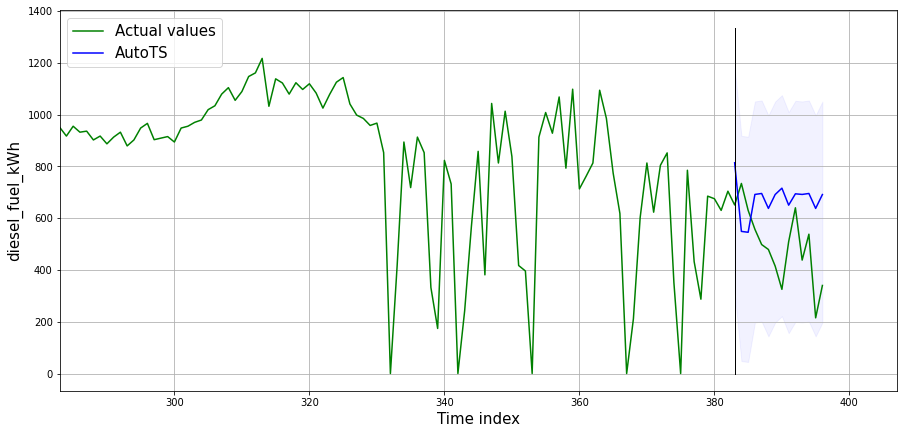

MAE - 212.14
RMSE - 56645.40


In [13]:
show_autots_results(actual_time_series=disel,
                    prediction=prediction,
                    len_train_data=len(disel) - forecast_length)

## pmdarima

In [14]:
import pmdarima as pm
from pmdarima import model_selection

# Additional imports
import pandas as pd
import numpy as np

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7


def plot_arima_results(actual_time_series, predicted_values, 
                       conf_int, len_train_data, y_name='Parameter'):
    """
    Function for drawing plot with predictions

    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param conf_int: array with confidence interval 
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """

    plt.plot(np.arange(0, len(actual_time_series)),
             actual_time_series, label='Actual values', c='green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)),
             predicted_values, label='pmdarima', c='blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c='black', linewidth=1)
    plt.fill_between(np.arange(len_train_data, len_train_data + len(predicted_values)),
                     conf_int[:, 0], conf_int[:, 1], color='b', alpha=.05)
    plt.ylabel(y_name, fontsize=15)
    plt.xlabel('Time index', fontsize=15)
    plt.legend(fontsize=15, loc='upper left')
    plt.xlim(len_train_data - 100, len(actual_time_series) + 10)
    plt.grid()
    plt.show()

In [15]:
df_filled = pd.read_csv('pw_filled.csv')
df_filled['datetime'] = pd.to_datetime(df_filled['datetime'])

# Actual time series
disel = np.array(df_filled['diesel_fuel_kWh'])

# Define forecast length
forecast_length = 14

df_train, df_val = train_test_split_df(df_filled, validation_elements=forecast_length)

In [16]:
# Fit your model
model = pm.auto_arima(np.array(df_train['diesel_fuel_kWh']), 
                      seasonal=False,
                      stationary=True,
                      maxiter=150)

# Make forecasts
pdarima_forecast, conf_int = model.predict(forecast_length, return_conf_int=True, alpha=0.1)

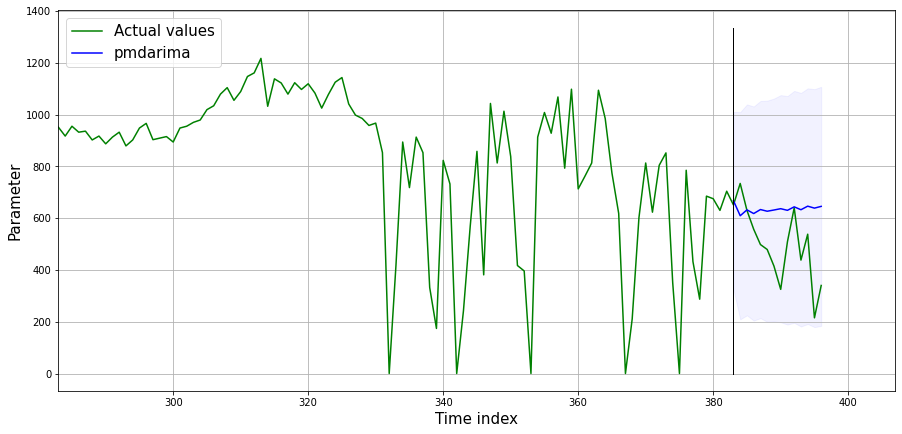

MAE - 155.13
RMSE - 38617.23


In [17]:
# Plot results
plot_arima_results(actual_time_series=disel,
                   predicted_values=pdarima_forecast,
                   conf_int=conf_int,
                   len_train_data=len(disel) - forecast_length)

test_target = np.array(df_val['diesel_fuel_kWh'])
mse_metric = mean_squared_error(test_target, pdarima_forecast)
mae_metric = mean_absolute_error(test_target, pdarima_forecast)

print(f'MAE - {mae_metric:.2f}')
print(f'RMSE - {mse_metric:.2f}')

## FEDOT

In [5]:
# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum

# Train and test split 
from fedot.core.data.data import train_test_data_setup

# Composite models in FEDOT
from fedot.core.chains.chain import Chain
from fedot.core.chains.node import PrimaryNode, SecondaryNode


def plot_fedot_results(actual_time_series, predicted_values, len_train_data, y_name='Parameter'):
    """
    Function for drawing plot with predictions

    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """

    plt.plot(np.arange(0, len(actual_time_series)),
             actual_time_series, label='Actual values', c='green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)),
             predicted_values, label='FEDOT', c='blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c='black', linewidth=1)
    plt.ylabel(y_name, fontsize=15)
    plt.xlabel('Time index', fontsize=15)
    plt.legend(fontsize=15, loc='upper left')
    plt.xlim(len_train_data - 100, len(actual_time_series) + 10)
    plt.grid()
    plt.show()

In [6]:
# Create a chain
node_lagged = PrimaryNode('lagged')
node_lagged.custom_params = {'window_size': 13}

node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged])
node_knnreg.custom_params = {'p': 2, 'weights': 'distance', 'n_neighbors': 4}
chain = Chain(node_knnreg)

In [7]:
df_filled = pd.read_csv('pw_filled.csv')

# Define forecast length
forecast_length = 14

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))

# Get time series from dataframe
disel = np.array(df_filled['diesel_fuel_kWh'])
input_data = InputData(idx=np.arange(0, len(disel)),
                       features=disel,
                       target=disel,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Split data into train and test
train_input, validation_input = train_test_data_setup(input_data)

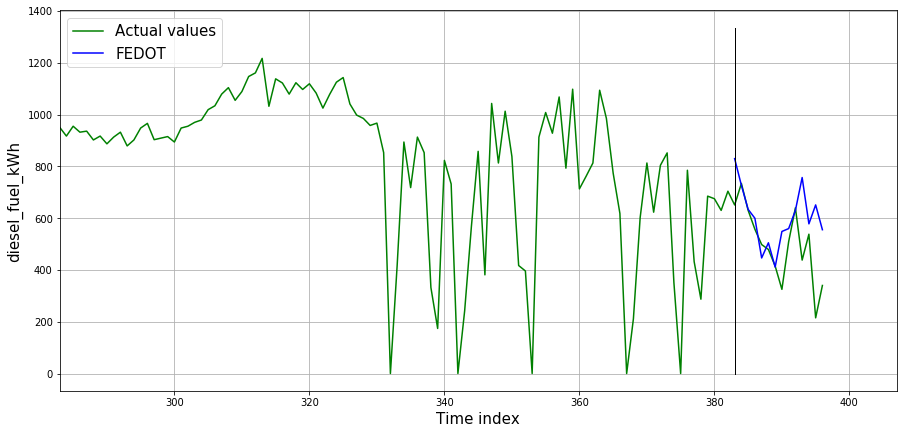

MAE - 114.92
RMSE - 30692.18


In [8]:
chain.fit(train_input)

output = chain.predict(validation_input)
fedot_forecast = np.ravel(np.array(output.predict))

plot_fedot_results(disel, fedot_forecast, 
                   len(train_input.features), 
                   y_name='diesel_fuel_kWh')

mse_metric = mean_squared_error(validation_input.target, fedot_forecast)
mae_metric = mean_absolute_error(validation_input.target, fedot_forecast)

print(f'MAE - {mae_metric:.2f}')
print(f'RMSE - {mse_metric:.2f}')

## Comparison

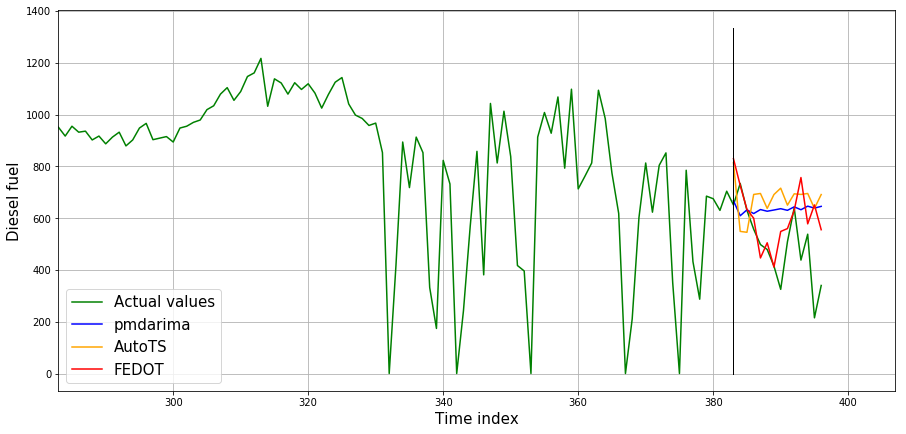

In [9]:
# Length of train time series
len_train_data = len(train_input.features)

plt.plot(np.arange(0, len(disel)),
         disel, label='Actual values', c='green')

plt.plot(np.arange(len_train_data, len_train_data + len(fedot_forecast)),
         pdarima_forecast, label='pmdarima', c='blue')
plt.plot(np.arange(len_train_data, len_train_data + len(fedot_forecast)),
         autots_forecast, label='AutoTS', c='orange')
plt.plot(np.arange(len_train_data, len_train_data + len(fedot_forecast)),
         fedot_forecast, label='FEDOT', c='red')
# Plot black line which divide our array into train and test
plt.plot([len_train_data, len_train_data],
         [min(disel), max(disel)], c='black', linewidth=1)
plt.ylabel('Diesel fuel', fontsize=15)
plt.xlabel('Time index', fontsize=15)
plt.legend(fontsize=15, loc='lower left')
plt.xlim(len_train_data - 100, len(disel) + 10)
plt.grid()
plt.show()

## H2O

In [23]:
import h2o

def _get_h2o_connect_config():
    IP = '127.0.0.1'
    PORT = 8888
    return IP, PORT

In [24]:
ip, port = _get_h2o_connect_config()
h2o.init(ip=ip, port=port, name='h2o_server')

Checking whether there is an H2O instance running at http://127.0.0.1:8888 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from C:\Users\user\anaconda3\envs\arima\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmprv4_ejp9
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmprv4_ejp9\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmprv4_ejp9\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:8890
Connecting to H2O server at http://127.0.0.1:8890 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,h2o_server
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.957 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"
